<a href="https://colab.research.google.com/github/ealbenque/eurocode_3_steel/blob/main/notebooks/1.0-ea-draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###dependencies



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import seaborn as sns

scaler = MinMaxScaler()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

###generation of training data

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path
file_path = '/content/drive/MyDrive/Colab Notebooks/EC3/EC3-section_and_stability.xls'

df = pd.read_excel(file_path,sheet_name='IPE_simple')
df = df[['section','Iy','Wy']]
df = df.drop(axis=0, index=0)
df

Mounted at /content/drive


,section,Iy,Wy
1,IPE 80,801400,20030
2,IPE100,1710000,34200
3,IPE120,3178000,52960
4,IPE140,5412000,77320
5,IPE160,8693000,108700
6,IPE180,13170000,146300
7,IPE200,19430000,194300
8,IPE220,27720000,252000
9,IPE240,38920000,324300
10,IPE270,57900000,428900


In [ ]:
X = np.empty((0,2))
y = np.empty(0,dtype=int)
z = np.empty((0,),dtype=str)

crit = 200
L_list = np.linspace(2,15,num=100)
p_list = np.linspace(100,10000,num=100)
E_s = 210000000000 #Pa = N/m²
f_y = 235000000 #Pa = N/m²
section_check = 0

for L in L_list :
    i= 1
    for p in p_list:
        section_check = 0
        while (section_check ==0) & (i <= len(df)+1) :
            S_i = df.loc[i,'section']
            I_y_i = df.loc[i,'Iy']
            crit_i = 384 * E_s*I_y_i*10**(-12)/(5 *p*L**3)
            if crit_i>crit:
                section_check = 1
                X = np.append(X,[[L,p]],axis=0)
                y = np.append(y,i)
                z = np.append(z,[S_i],axis=0)
            else:
                i+=1

In [ ]:
print(len(df))

17


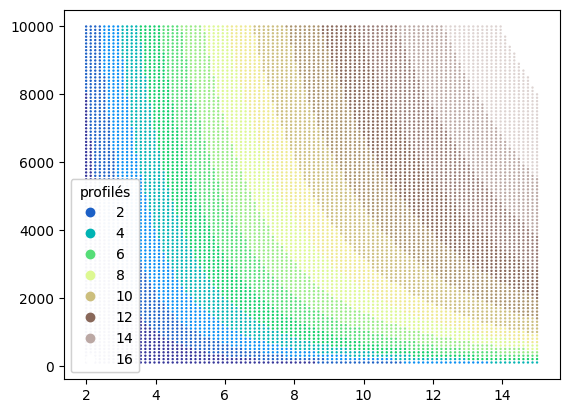

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(X[:,0],X[:,1], c=y[:], cmap='terrain',s=0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="profilés")
ax.add_artist(legend1)

plt.show()

In [ ]:
X = scaler.fit_transform(X)
print(X)

[[0.         0.        ]
 [0.         0.01010101]
 [0.         0.02020202]
 ...
 [1.         0.97979798]
 [1.         0.98989899]
 [1.         1.        ]]


###build model

In [ ]:
# Set the hyperparameters
NUM_CLASSES = 17
NUM_FEATURES = 2
RANDOM_SEED = 42

In [ ]:
print(y[:500])
print(X)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 

tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        [0.0000, 0.0303],
        [0.0000, 0.0404]]) tensor([1, 1, 1, 1, 1])


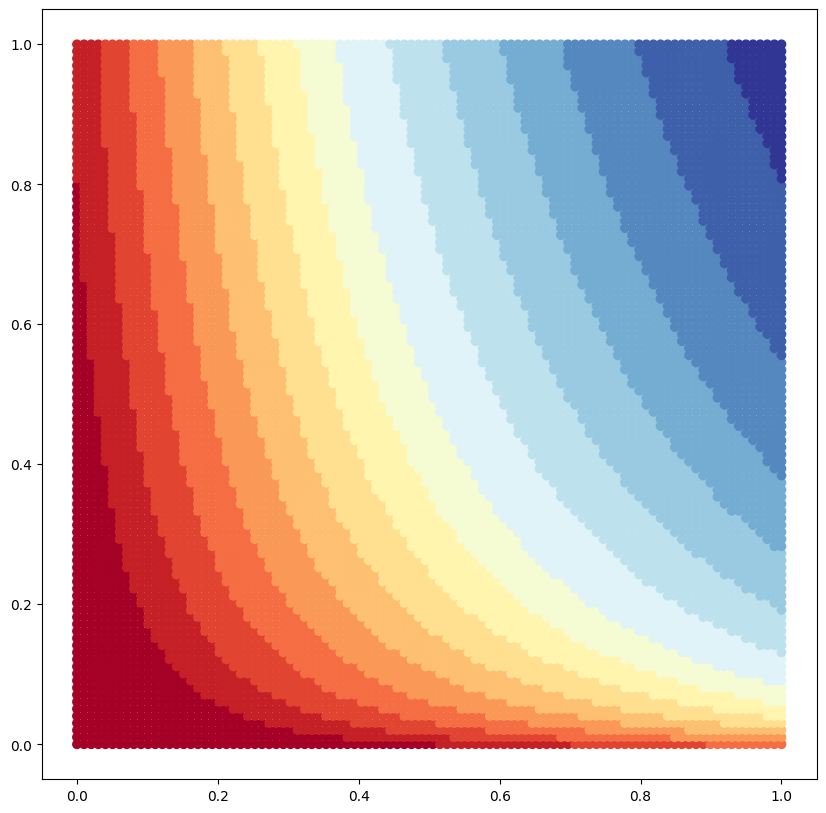

In [ ]:
# 2. Turn data into tensors
X_ = torch.from_numpy(X).type(torch.float)
y_ = torch.from_numpy(y).type(torch.LongTensor)
print(X_[:5], y_[:5])

# 3. Split into train and test sets
X__train, X__test, y__train, y__test = train_test_split(X_,
    y_,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 10))
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=plt.cm.RdYlBu);

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Build model
class Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=32):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of Model and send it to the target device
model_4 = Model(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=32).to(device)
model_4

Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=17, bias=True)
  )
)

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01)

In [ ]:
# How many elements in a single prediction sample?
model_4(X__train.to(device))[0].shape, NUM_CLASSES

NameError: name 'X__train' is not defined

In [ ]:
# Make prediction logits with model
y_logits = model_4(X__test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0209,  0.1499,  0.0431, -0.0609,  0.0024,  0.1291,  0.2372, -0.1313,
          0.1554,  0.0528,  0.0357,  0.0362,  0.0423,  0.1182,  0.0996,  0.1767,
         -0.1212],
        [ 0.0098,  0.1715,  0.0794, -0.0492, -0.0407,  0.0952,  0.1773, -0.1028,
          0.1406,  0.0651,  0.0371,  0.0530,  0.0623,  0.1049,  0.1470,  0.1697,
         -0.1334],
        [-0.0280,  0.1334,  0.0281, -0.0479, -0.0487,  0.1317,  0.2253, -0.1228,
          0.1290,  0.0813,  0.0817,  0.0039,  0.0294,  0.1407,  0.1087,  0.1949,
         -0.1030],
        [-0.0317,  0.1458,  0.0339, -0.0547, -0.0129,  0.1335,  0.2365, -0.1255,
          0.1445,  0.0604,  0.0516,  0.0235,  0.0343,  0.1276,  0.0953,  0.1832,
         -0.1140],
        [-0.0383,  0.1308,  0.0271, -0.0670, -0.0132,  0.1361,  0.2476, -0.1313,
          0.1424,  0.0616,  0.0601,  0.0178,  0.0302,  0.1300,  0.1030,  0.2077,
         -0.1091]], grad_fn=<SliceBackward0>)
tensor([[0.0542, 0.0643, 0.0578, 0.0521, 0.0555, 0.0630, 0.0702, 0.0

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0542, 0.0643, 0.0578, 0.0521, 0.0555, 0.0630, 0.0702, 0.0486, 0.0647,
        0.0584, 0.0574, 0.0574, 0.0578, 0.0623, 0.0612, 0.0661, 0.0491],
       grad_fn=<SelectBackward0>)
tensor(6)


In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 10000

# Put data to target device
X__train, y__train = X__train.to(device), y__train.to(device)
X__test, y__test = X__test.to(device), y__test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X__train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y__train)
    acc = accuracy_fn(y_true=y__train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X__test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y__test)
      test_acc = accuracy_fn(y_true=y__test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.83301, Acc: 5.19% | Test Loss: 2.82942, Test Acc: 5.65%
Epoch: 10 | Loss: 2.81275, Acc: 5.47% | Test Loss: 2.81027, Test Acc: 5.75%
Epoch: 20 | Loss: 2.79770, Acc: 7.21% | Test Loss: 2.79587, Test Acc: 7.45%
Epoch: 30 | Loss: 2.78451, Acc: 8.01% | Test Loss: 2.78296, Test Acc: 8.35%
Epoch: 40 | Loss: 2.77194, Acc: 11.41% | Test Loss: 2.77064, Test Acc: 11.60%
Epoch: 50 | Loss: 2.76036, Acc: 10.57% | Test Loss: 2.75947, Test Acc: 11.10%
Epoch: 60 | Loss: 2.75004, Acc: 11.06% | Test Loss: 2.74949, Test Acc: 11.20%
Epoch: 70 | Loss: 2.74079, Acc: 11.62% | Test Loss: 2.74050, Test Acc: 11.40%
Epoch: 80 | Loss: 2.73247, Acc: 11.84% | Test Loss: 2.73234, Test Acc: 11.70%
Epoch: 90 | Loss: 2.72483, Acc: 12.07% | Test Loss: 2.72476, Test Acc: 11.90%
Epoch: 100 | Loss: 2.71759, Acc: 11.75% | Test Loss: 2.71745, Test Acc: 11.30%
Epoch: 110 | Loss: 2.71049, Acc: 11.05% | Test Loss: 2.71022, Test Acc: 10.55%
Epoch: 120 | Loss: 2.70333, Acc: 10.62% | Test Loss: 2.70284, Test Acc:

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X__test)

# View the first 10 predictions
y_logits[:10]

tensor([[-10.5525, -20.6737, -12.3116,  -6.6936,  -2.9770,  -0.0901,   2.1092,
           3.9825,   5.8169,   7.1955,   8.6621,   8.6992,   8.8779,   6.3364,
           5.2708,   1.0825,   2.6946],
        [-10.5739, -18.2833,  -9.6242,  -4.7344,  -1.4794,   1.0108,   2.9588,
           4.6069,   6.1210,   7.3007,   8.3491,   7.8822,   7.4196,   4.2850,
           2.8080,  -1.4953,   0.7678],
        [-10.1243,  15.8055,  16.6667,  16.5221,  16.0147,  15.0279,  13.7240,
          11.8510,   9.7421,   6.9529,   3.4651,  -2.8416,  -8.9958, -17.3832,
         -23.8733, -32.2521, -25.5948],
        [-10.4575,  -7.5848,  -1.9133,   1.6718,   3.8515,   5.4415,   6.4546,
           7.1353,   7.4484,   7.2458,   6.7498,   4.4834,   2.2822,  -2.2640,
          -5.4010, -11.1586,  -7.6955],
        [-10.4426,   1.2932,   4.8337,   7.1979,   8.4687,   9.2015,   9.3735,
           9.1421,   8.4619,   7.2044,   5.4981,   1.6994,  -2.0143,  -7.9443,
         -12.3804, -19.2916, -14.7343],
        [-

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y__test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y__test, y_pred=y_preds)}%")

Predictions: tensor([12, 10,  2,  8,  6, 10,  2,  5, 12,  1])
Labels: tensor([11, 10,  3,  9,  7, 10,  3,  3, 12,  1])
Test accuracy: 47.8%


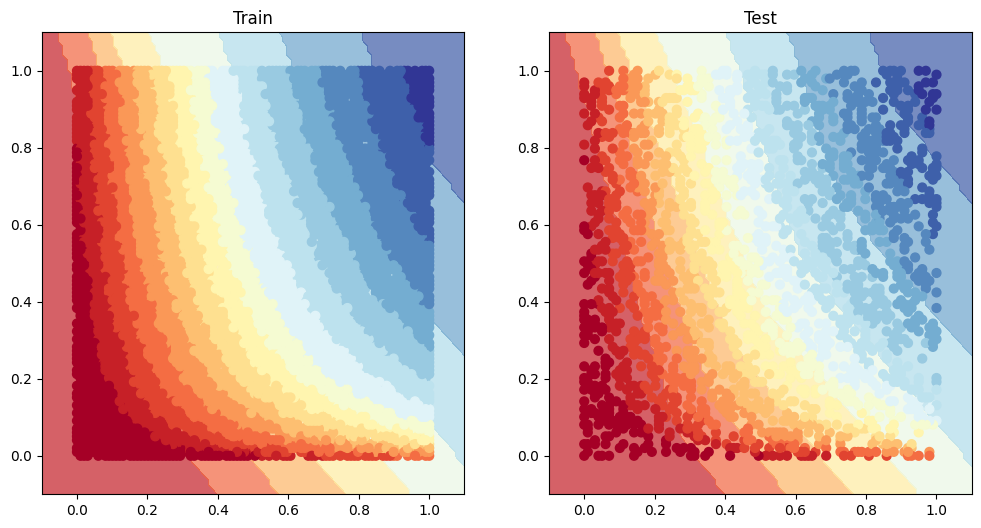

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X__train, y__train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X__test, y__test)